# CS441: Applied ML - HW 4

## Part I: Clustering and Fast Retrieval

Include all the code for Part 1 in this section

In [1]:
!apt install libomp-dev
!pip install faiss-cpu

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libomp-10-dev libomp5-10
Suggested packages:
  libomp-10-doc
The following NEW packages will be installed:
  libomp-10-dev libomp-dev libomp5-10
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 351 kB of archives.
After this operation, 2,281 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 libomp5-10 amd64 1:10.0.0-4ubuntu1 [300 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libomp-10-dev amd64 1:10.0.0-4ubuntu1 [47.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 libomp-dev amd64 1:10.0-50~exp1 [2,824 B]
Fetched 351 kB in 2s (178 kB/s)
Selecting previously unselected package libomp5-10:amd64.
(Reading database ... 122349 files and directories currently installed.)
Preparing to unpack .../libomp5-10_1%3a10.0.0-4ubuntu1_amd64.

In [2]:
# initialization code
import numpy as np
from keras.datasets import mnist
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.linear_model import LogisticRegression
import time
import faiss
from google.colab import drive
from google.colab.patches import cv2_imshow
import cv2
# loads MNIST data and reformat to 768-d vectors with values in range 0 to 1
# splits into train/val/test sets and provides indices for subsets of train
def load_mnist():
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  x_train = np.reshape(x_train, (len(x_train), 28*28))
  x_test = np.reshape(x_test, (len(x_test), 28*28))
  maxval = x_train.max()
  x_train = x_train/maxval
  x_test = x_test/maxval
  x_val = x_train[:10000]
  y_val = y_train[:10000]
  x_train = x_train[10000:]
  y_train = y_train[10000:]
  train_indices = dict()
  train_indices['xs'] = np.arange(50)
  train_indices['s'] = np.arange(500)
  train_indices['m'] = np.arange(5000)
  train_indices['all'] = np.arange(50000)
  return (x_train, y_train), (x_val, y_val), (x_test, y_test), train_indices

# displays a set of mnist images (can print 1 row OR 1 column)
def display_mnist(x, subplot_rows=1, subplot_cols=1):
  s = np.ceil(max(subplot_rows, subplot_cols)/10)
  if subplot_rows>1 or subplot_cols>1:
      fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(15,15))
      for i in range(len(x)):
        ax[i].imshow(np.reshape(x[i], (28,28)), cmap='gray')
        ax[i].axis('off')
  else:
      plt.imshow(np.reshape(x, (28,28)), cmap='gray')
      plt.axis('off')
  plt.show()

# counts the number of examples per class
def class_count_mnist(y):
  count = np.zeros((10,),dtype='uint32')
  for i in np.arange(10):
    count[i] = sum(y==i)
  return count

11490434/11490434 [==============================] - 1s 0us/step


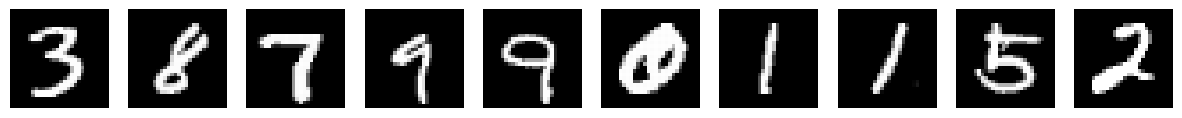

Total size: train=50000, val=10000, test =10000
Train subset size: xs=50, s=500, m=5000, all=50000
Class count for s: [56 57 51 49 46 46 50 51 40 54]


In [3]:
# example of using MNIST load, display, indices, and count functions
(x_train, y_train), (x_val, y_val), (x_test, y_test), train_indices = load_mnist()
display_mnist(x_train[:10],1,10)
print('Total size: train={}, val={}, test ={}'.format(len(x_train), len(x_val), len(x_test)))
print('Train subset size: xs={}, s={}, m={}, all={}'.format(len(train_indices['xs']),len(train_indices['s']),len(train_indices['m']),len(train_indices['all'])))
print('Class count for s: {}'.format(class_count_mnist(y_train[train_indices['s']])))

In [4]:
## Helper functions

# Returns the purity of the clustering according to labels, 
# and the label counts of each cluster
def get_purity(labels, cluster_idx):
  nclasses = int(max(labels)+1)
  nidx = int(max(cluster_idx)+1)
  counts = np.zeros((nidx, nclasses), np.int32)
  for i in range(len(labels)):
    c = labels[i]
    idx = cluster_idx[i]
    counts[idx, c]+=1
  purity = np.sum(np.max(counts, axis=1))/len(cluster_idx)
  return purity, counts

# Returns an index list that can be used to re-order the counts according to 
# which label is most common 
def get_cluster_order(counts):
  idx = np.argmax(counts, axis=1)
  idx = np.argsort(idx)
  return idx 

###*Problem* 1.1 Clustering

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Purity for K = 10: 0.5914
Mean distance for K = 10: 6.2024


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Purity for K = 20: 0.7076
Mean distance for K = 20: 5.9050


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Purity for K = 30: 0.7557
Mean distance for K = 30: 5.7035


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Purity for K = 40: 0.7938
Mean distance for K = 40: 5.5884


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Purity for K = 50: 0.8197
Mean distance for K = 50: 5.5625


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Purity for K = 60: 0.8202
Mean distance for K = 60: 5.4398


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Purity for K = 70: 0.8392
Mean distance for K = 70: 5.4311


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Purity for K = 80: 0.8578
Mean distance for K = 80: 5.3631


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Purity for K = 90: 0.8660
Mean distance for K = 90: 5.3174


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Purity for K = 100: 0.8732
Mean distance for K = 100: 5.2811


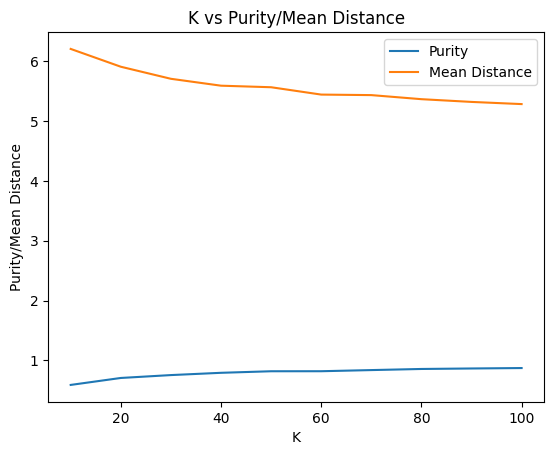

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

# set dimensions
dim = x_train.shape[1]

# Set the number of clusters
clusters =  [10, 20, 30,40,50,60,70,80,90, 100]

purity_k = []
mean_k = []

for K in clusters:
  # Initialize the k-means clustering object
  kmeans = KMeans(n_clusters=K, random_state=0)


  # Train the k-means model
  kmeans.fit(x_train)


  # Assign each data point to a cluster
  y_pred = kmeans.predict(x_train)


  # Record and print Purity
  label_counts = np.bincount(y_pred)
  cluster_labels = [np.argmax(np.bincount(y_train[y_pred == i])) for i in range(K)]
  cluster_label_counts = [np.sum(y_train[y_pred == i] == cluster_labels[i]) for i in range(K)]
  purity = np.sum(cluster_label_counts) / np.sum(label_counts)
  print("Purity for K = %d: %.4f" % (K, purity))
  purity_k.append(purity)
  
  #Get Cluster indexes & Display the centroids
  cluster_indexes = [np.where(y_pred == i)[0] for i in range(K)]
  centroids = kmeans.cluster_centers_

  
  # Record and print Average Distance
  mean_distance = np.mean([np.mean(pairwise_distances(x_train[cluster_indexes[i]], [centroids[i]], metric='euclidean')) for i in range(K)])
  print("Mean distance for K = %d: %.4f" % (K, mean_distance))
  mean_k.append(mean_distance)


#Plot K vs Purity and K vs Mean_Distances
plt.plot(clusters, purity_k, label="Purity")
plt.plot(clusters, mean_k, label="Mean Distance")
plt.xlabel("K")
plt.ylabel("Purity/Mean Distance")
plt.title("K vs Purity/Mean Distance")
plt.legend()
plt.show()

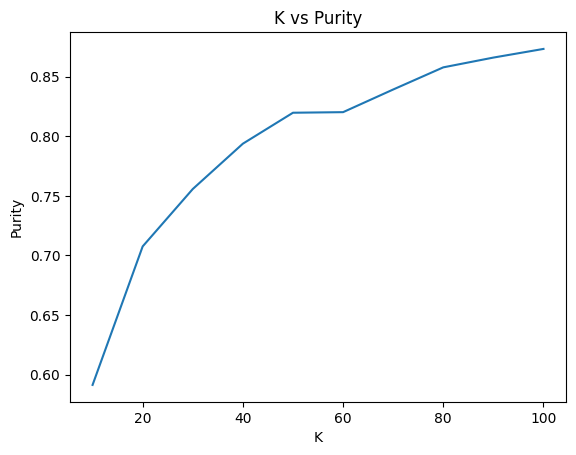

In [ ]:
import matplotlib.pyplot as plt

plt.plot(clusters, purity_k)
plt.xlabel('K')
plt.ylabel('Purity')
plt.title('K vs Purity')
plt.show()


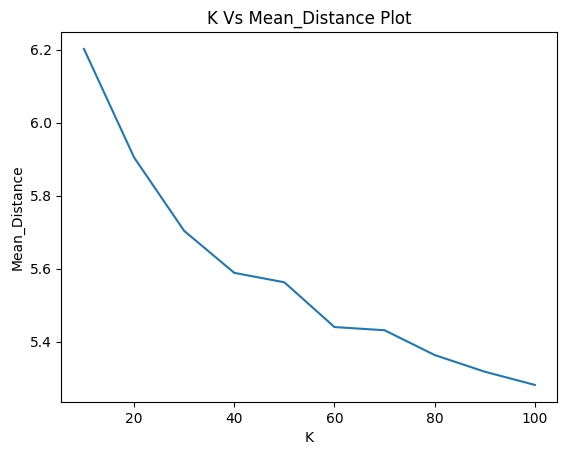

In [ ]:
import matplotlib.pyplot as plt

plt.plot(clusters, mean_k)
plt.xlabel('K')
plt.ylabel('Mean_Distance')
plt.title('K Vs Mean_Distance Plot')
plt.show()


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


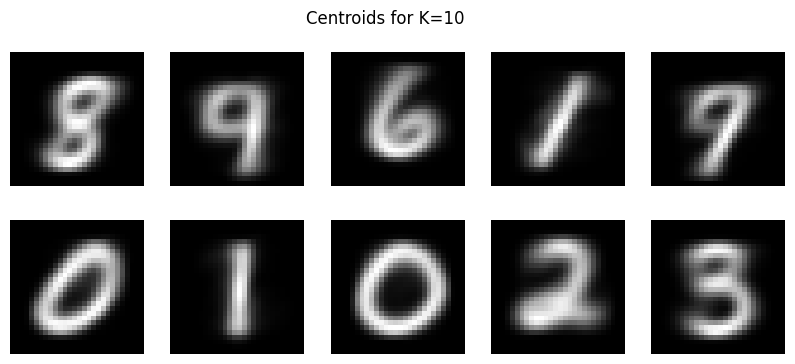

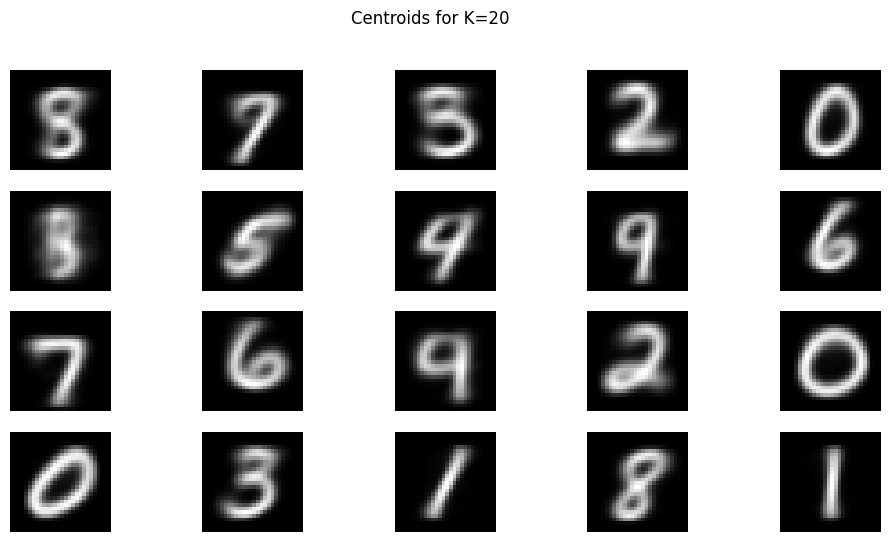

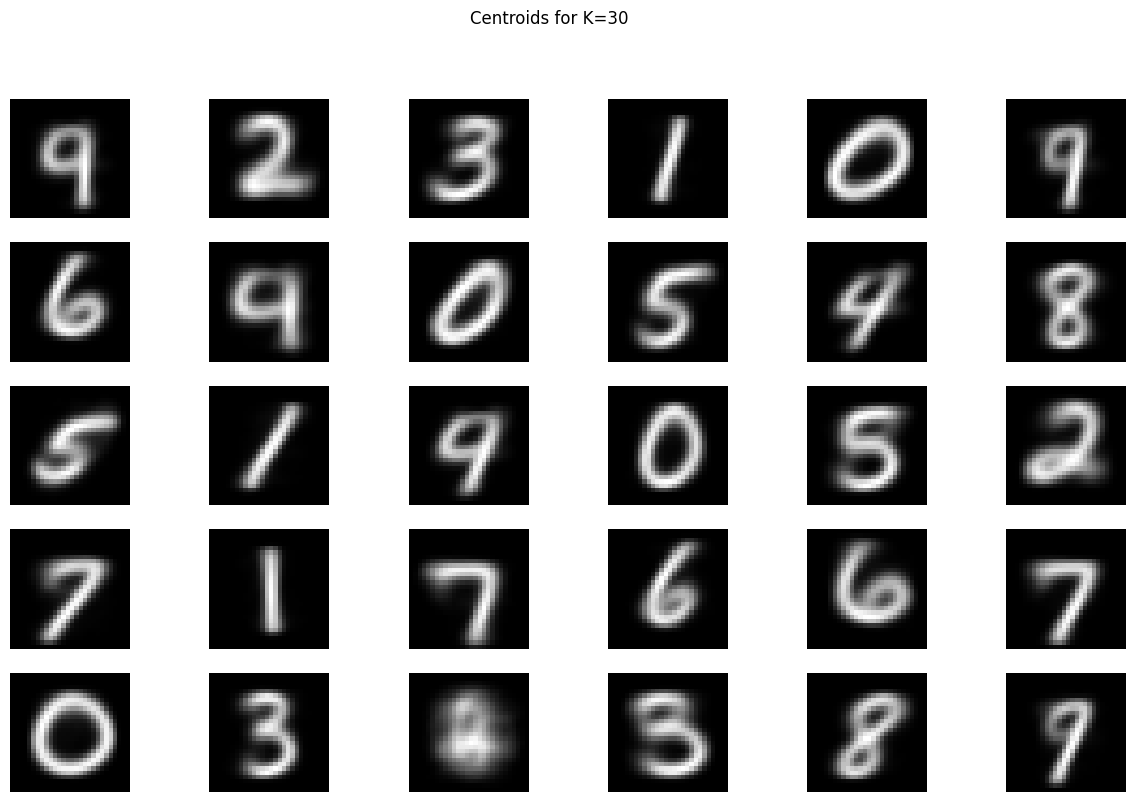

In [ ]:
# fit KMeans model for K = 10, 20, 30
kmeans_10 = KMeans(n_clusters=10, random_state=0).fit(x_train)
kmeans_20 = KMeans(n_clusters=20, random_state=0).fit(x_train)
kmeans_30 = KMeans(n_clusters=30, random_state=0).fit(x_train)

# get cluster centroids
centroids_10 = kmeans_10.cluster_centers_
centroids_20 = kmeans_20.cluster_centers_
centroids_30 = kmeans_30.cluster_centers_

# plot centroids for K = 10
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(centroids_10[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle('Centroids for K=10')

# plot centroids for K = 20
plt.figure(figsize=(12, 6))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(centroids_20[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle('Centroids for K=20')

# plot centroids for K = 30
plt.figure(figsize=(15, 9))
for i in range(30):
    plt.subplot(5, 6, i+1)
    plt.imshow(centroids_30[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle('Centroids for K=30')

plt.show()


### Problem 1.2 Fast Retrieval

In [5]:
## Brute Force (IndexFlatL2)

# set dimensions
dim = x_train.shape[1]

start_time = time.time()

# Initialize the index for Brute Force
index = faiss.IndexFlatL2(dim)

# Add Data & Print time to add
index.add(x_train)
print("Time to add: %.4f seconds" % (time.time() - start_time))



# Perform Search and Compute Time required
k = 10
D, I = index.search(x_test, k)
search_time = time.time() - start_time


# Compute Test Error
test_error = 0
for i in range(x_test.shape[0]):
    indices = I[i]
    nearest_labels = y_train[indices]
    test_error += 1 if y_test[i] not in nearest_labels else 0
test_error = test_error / x_test.shape[0]

print("Brute Force (IndexFlatL2) test error: %.4f" % test_error)
print("Brute Force (IndexFlatL2) search time: %.4f seconds" % search_time)





Time to add: 0.2116 seconds
Brute Force (IndexFlatL2) test error: 0.0059
Brute Force (IndexFlatL2) search time: 17.9665 seconds


In [6]:
from math import ceil, log2
## LSH

# set dimensions
dim = x_train.shape[1]

start_time = time.time()
# Initialize the index for LSH
index = faiss.IndexLSH(dim, 10)

# Add Data & Print time to add
index.add(x_train)
print("Time to add:", time.time()-start_time)


# Perform Search and Compute Time required
start_time = time.time()
D, I = index.search(x_test, 10)
search_time = time.time() - start_time
print("Time to search:", search_time)

#Initialise/defining the computer error function
def compute_error(I, y_train, y_test):
    # Initialize error
    error = 0
    
    # Loop over test examples
    for i in range(len(I)):
        # Get indices of nearest neighbors
        neighbors = I[i]
        
        # Get corresponding training labels
        neighbor_labels = y_train[neighbors]
        
        # Compute mode of labels
        mode_label = np.argmax(np.bincount(neighbor_labels))
        
        # Check if predicted label matches true label
        if mode_label != y_test[i]:
            error += 1
    
    # Compute error rate
    error_rate = error / len(y_test)
    
    return error_rate

# Compute Test Error
test_error = compute_error(I, y_train, y_test)
print("Test error:", test_error)
print("Nbits: ", ceil(log2(50000)) * 16)


Time to add: 0.22899317741394043
Time to search: 3.1586265563964844
Test error: 0.6079
Nbits:  256


In [ ]:
# drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## Part 2: Estimating PDFs

In [ ]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import time
import faiss
from google.colab import drive
from google.colab.patches import cv2_imshow
import cv2

drive.mount('/content/drive')
datadir = "/content/drive/My Drive/CS441/hw4/" # revise as needed
im = cv2.imread(datadir + '3985783648_4702b45d13_c.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)/255  # converts to RGB ordering and values between 0 and 1
crop = cv2.imread(datadir + '3985783648_4702b45d13_c_crop.jpg')
crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)/255

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# print(im)

In [ ]:
def display_score_maps(im, score_map, thresh):
  '''
    Input: im (h, w, 3): RGB image
           score_map (h, w, 1) or (h*w, 1)
           thresh: floating point threshold, typically between -2 and 2
  '''
  plt.imshow(im)
  plt.axis('off')
  plt.show()
  plt.imshow(np.reshape(score_map, (im.shape[:2])))
  plt.axis('off')
  plt.show()
  plt.imshow(np.reshape(score_map>thresh, (im.shape[0], im.shape[1])), cmap='gray')
  plt.axis('off')
  plt.show()
  plt.imshow(np.tile(np.reshape(score_map>thresh, (im.shape[0], im.shape[1], 1)), (1,1,3))*im)
  plt.axis('off')
  plt.show()

In [ ]:
# Generate a score map
score_map = np.random.rand(im.shape[0], im.shape[1], 1)

# Display the score map
#display_score_maps(im, score_map, 0.5)

#### Method 1 (Per-dimension discrete pdf)

In [ ]:
# estimate discrete pdf
def estimate_discrete_pdf(x, K, prior=1):
  '''
    Input: x(nx, ): an array of discrete values from 0 to K-1
           K: number of possible discrete values
           prior: initial count for each discrete value
    Output: p(nvalues, ): p[i] is the estimated probability of discrete value i
    
    This function can be used for Method 1 and Method 2
  '''

  p = np.ones(K,)*prior # initialize p 
  counts = np.bincount(x, minlength=K) # count the number of occurrences of each value in x
  p += counts # add the counts to the prior
  p /= np.sum(p) # normalize to obtain the probabilities   
  return p

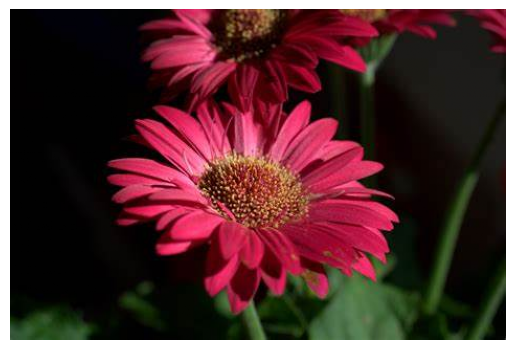

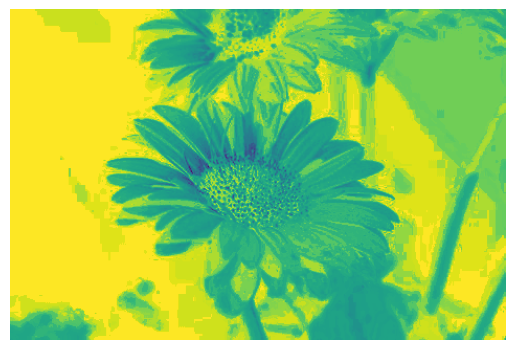

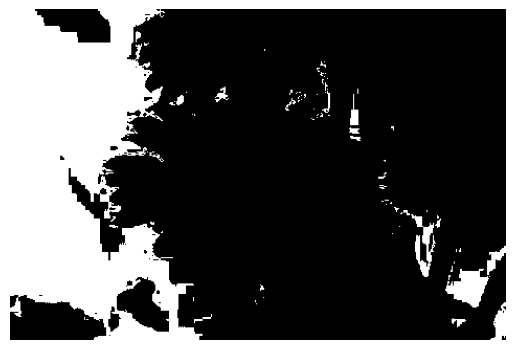

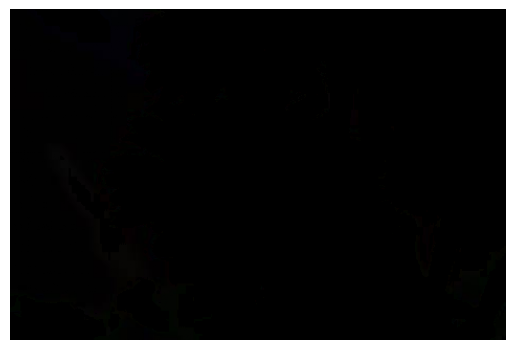

In [ ]:
# Set number of bins K
K = 32

# Reshape pixels to (h*w, 3)
pixels = im.reshape(-1, 3)

# Convert continuous values to discrete values ranging from 0 to K-1 
# e.g. x-->min(int(x*K), K-1) if x ranges from 0 to 1
pixels = (pixels*K).astype(int)
pixels = np.clip(pixels, 0, K-1)

# Get pdf for each dimension using estimate_discrete_pdf
pdfs = []
for i in range(3):
    pdf = estimate_discrete_pdf(pixels[:, i], K)
    pdfs.append(pdf)

# Estimate score for each pixel in full image according to log pdfs
scores = np.zeros((im.shape[0], im.shape[1]))
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        pixel = pixels[i*im.shape[1]+j]
        score = 0
        for k in range(3):
            score += np.log(pdfs[k][pixel[k]])
        scores[i,j] = score

# Display score maps, thresholded score maps, and thresholded RGB images
thresh = -3
display_score_maps(im, scores, thresh)


Using Histogram

In [ ]:
def estimate_histogram_pdf(x, K, prior=1):
  '''
    Input: x(nx, ): an array of continuous values from 0 to 1
           K: number of bins
           prior: initial count for each bin
    Output: p(nbins, ): p[i] is the estimated probability of bin i
    
    This function can be used for Method 1 and Method 2
  '''

  p = np.ones(K,)*prior # initialize p 
  counts, bins = np.histogram(x, bins=K, range=(0, 1)) # compute histogram counts
  p += counts # add the counts to the prior
  p /= np.sum(p) # normalize to obtain the probabilities   
  return p


In [8]:
# initialization code
import numpy as np
from keras.datasets import mnist
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.linear_model import LogisticRegression
import time
import faiss
from google.colab import drive
from google.colab.patches import cv2_imshow
import cv2

# loads MNIST data and reformat to 768-d vectors with values in range 0 to 1
# splits into train/val/test sets and provides indices for subsets of train
def load_mnist():
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  x_train = np.reshape(x_train, (len(x_train), 28*28))
  x_test = np.reshape(x_test, (len(x_test), 28*28))
  maxval = x_train.max()
  x_train = x_train/maxval
  x_test = x_test/maxval
  x_val = x_train[:10000]
  y_val = y_train[:10000]
  x_train = x_train[10000:]
  y_train = y_train[10000:]
  train_indices = dict()
  train_indices['xs'] = np.arange(50)
  train_indices['s'] = np.arange(500)
  train_indices['m'] = np.arange(5000)
  train_indices['all'] = np.arange(50000)
  return (x_train, y_train), (x_val, y_val), (x_test, y_test), train_indices

In [9]:
# displays a set of mnist images (can print 1 row OR 1 column)
def display_mnist(x, subplot_rows=1, subplot_cols=1):
  s = np.ceil(max(subplot_rows, subplot_cols)/10)
  if subplot_rows>1 or subplot_cols>1:
      fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(15,15))
      for i in range(len(x)):
        ax[i].imshow(np.reshape(x[i], (28,28)), cmap='gray')
        ax[i].axis('off')
  else:
      plt.imshow(np.reshape(x, (28,28)), cmap='gray')
      plt.axis('off')
  plt.show()

In [10]:
# counts the number of examples per class
def class_count_mnist(y):
  count = np.zeros((10,),dtype='uint32')
  for i in np.arange(10):
    count[i] = sum(y==i)
  return count

In [11]:
# example of using MNIST load, display, indices, and count functions
(x_train, y_train), (x_val, y_val), (x_test, y_test), train_indices = load_mnist()

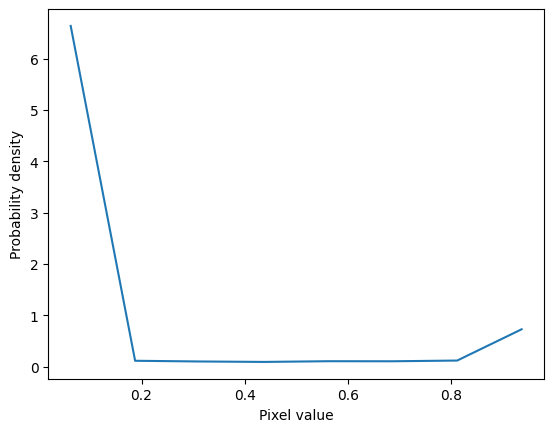

In [19]:
# use histogram to estimate PDF of pixel values in the training set
hist, bin_edges = np.histogram(x_train, bins=8, range=(0, 1), density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.plot(bin_centers, hist)
plt.xlabel('Pixel value')
plt.ylabel('Probability density')
plt.show()

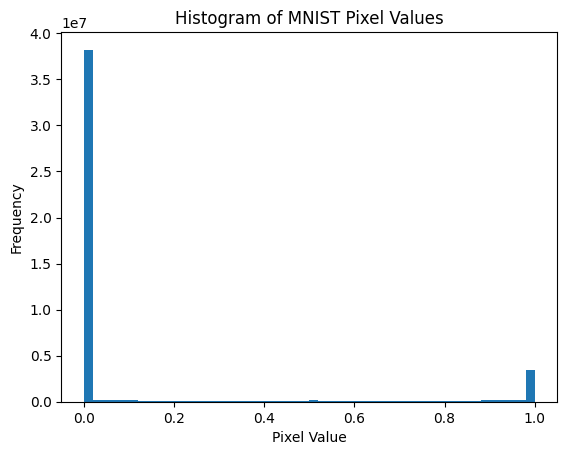

In [29]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt

# load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# normalize data to range [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# plot histogram of pixel values
plt.hist(x_train.flatten(), bins=50, range=[0, 1])
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Histogram of MNIST Pixel Values')
plt.show()


#### Method 2 (K-means)

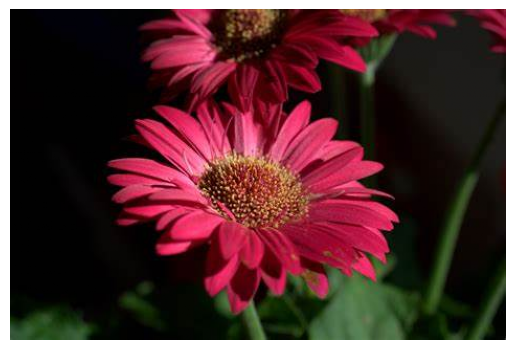

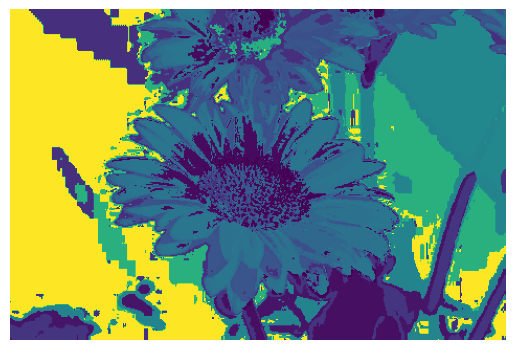

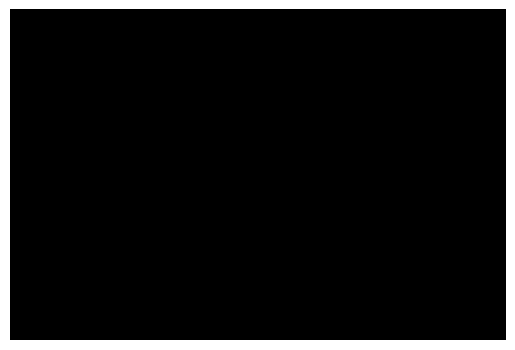

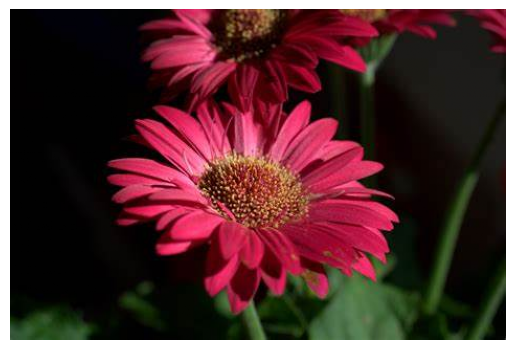

In [ ]:
import faiss

# set K
K = 16

# reshape pixels to (h*w, 3)
im_pixels = im.reshape((-1, 3))


# discretize all three color channels together using KMeans
kmeans = faiss.Kmeans(d=3, k=K)
kmeans.train(im_pixels.astype('float32'))
labels = kmeans.index.search(im_pixels.astype('float32'), 1)[1].reshape(im.shape[:2])

# get pdf over discrete values
pdf = estimate_discrete_pdf(labels.flatten(), K)

# estimate score for each pixel in full image according to log pdfs
scores = np.log(pdf[labels])

# display
display_score_maps(im, scores, -4)

#### Method 3 (GMM)

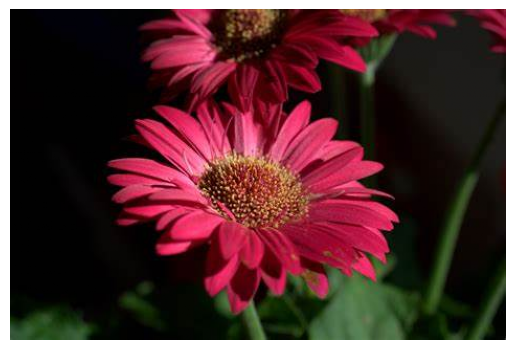

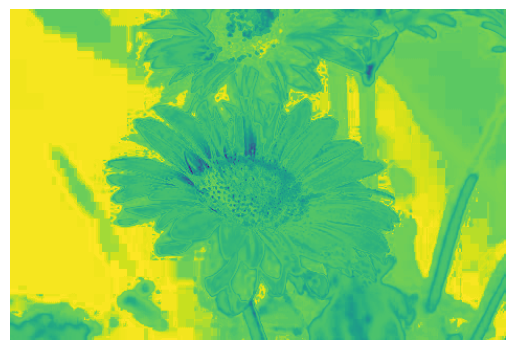

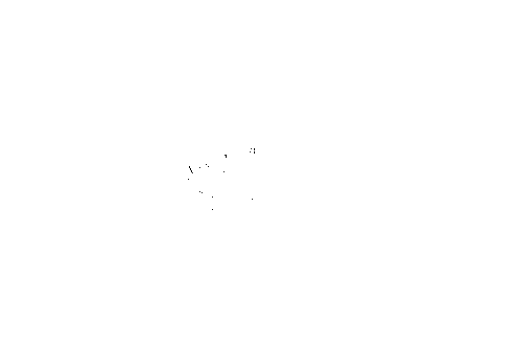

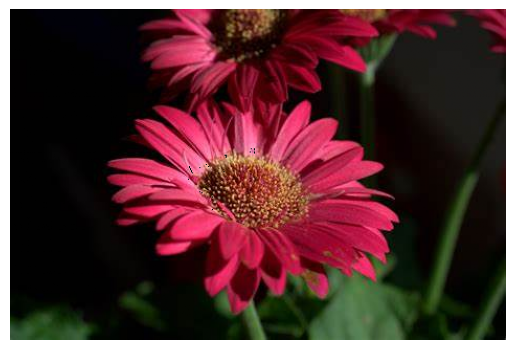

In [ ]:
from sklearn.mixture import GaussianMixture

# reshape pixels to (h*w, 3)
im_shape = im.shape
im_flat = np.reshape(im, (im_shape[0]*im_shape[1], im_shape[2]))

# get joint pdf using GMMs (choose number of components and other parameters)
n_components = 5
gmm = GaussianMixture(n_components=n_components, covariance_type='diag', random_state=0)
gmm.fit(im_flat)
pdf = gmm.score_samples(im_flat)

# estimate score for each pixel in full image according to log pdfs
score_map = np.reshape(pdf, (im_shape[0], im_shape[1]))
thresh = -10  # set threshold to determine which pixels to highlight

# display
display_score_maps(im, score_map, thresh)

## Part 3: PCA and Data Compression

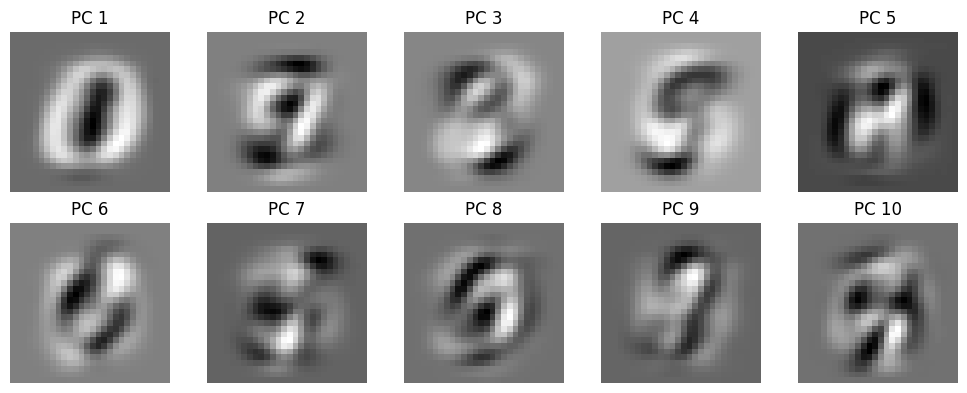

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import faiss

(x_train, y_train), (x_val, y_val), (x_test, y_test), train_indices = load_mnist()

# Compute the principal components using x_train
pca = PCA()
pca.fit(x_train)

# Display First 10 Components
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(pca.components_[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title(f"PC {i+1}")
plt.tight_layout()
plt.show()

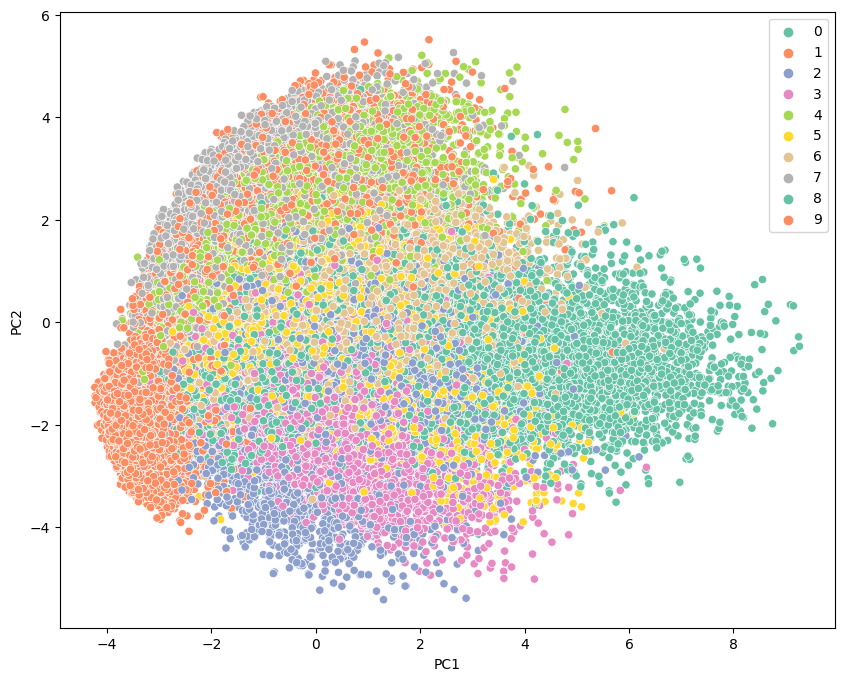

In [ ]:
# Scatter plot of first two PCA dimensions
from sklearn.decomposition import PCA
import seaborn as sns  #sns.scatterplot(x, y, hue=labels)
pca = PCA(n_components=2)
pca.fit(x_train)
x_pca = pca.transform(x_train)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=x_pca[:, 0], y=x_pca[:, 1], hue=y_train, palette='Set2')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

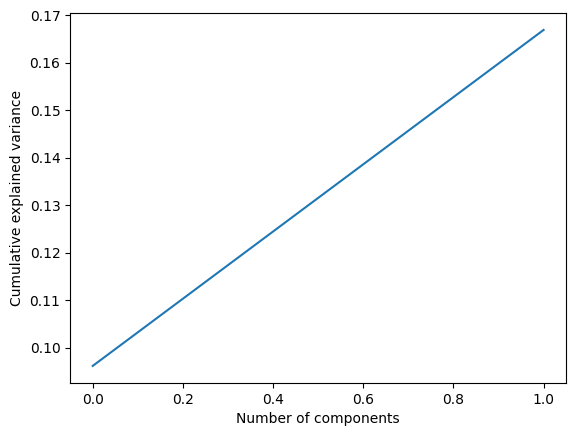

In [ ]:
cumulative_var = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.plot(cumulative_var)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()


In [ ]:
print(cumulative_var)

[0.09616912 0.16692974]


In [ ]:
print(x_train.shape)

(50000, 784)


Brute Force PCA

Brute force (PCA) search time: 0.0007410049438476562 seconds


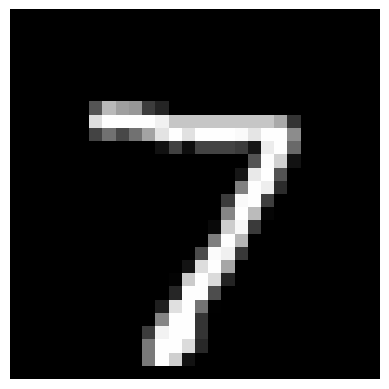

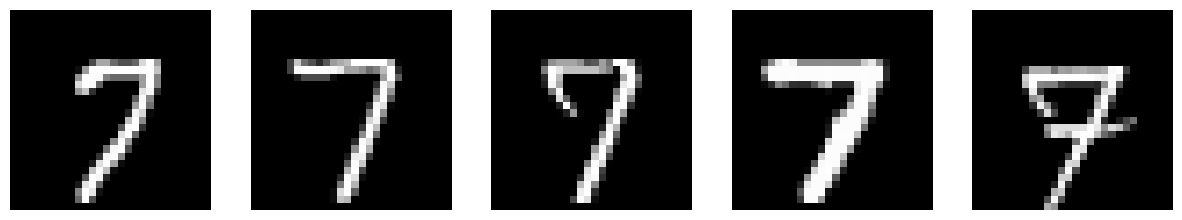

Prediction time: 0.2987985610961914 seconds
Test error: 16.63%


In [ ]:
# load MNIST data
(x_train, y_train), (x_val, y_val), (x_test, y_test), train_indices = load_mnist()

# reduce dimensionality of the data using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca.fit(x_train[train_indices['s']])
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

# perform brute force search on PCA-reduced data
import time
start_time = time.time()
d = 50  # dimensionality of the data
k = 5   # number of nearest neighbors to find
index = faiss.IndexFlatL2(d)
index.add(x_train_pca[train_indices['s']].astype(np.float32))
D, I = index.search(x_test_pca[:10], k)
brute_force_time = time.time() - start_time
print('Brute force (PCA) search time: {} seconds'.format(brute_force_time))

# display the nearest neighbors found for the first test image
display_mnist(x_test[:1],1,1)
display_mnist(x_train[I[0]],1,5)

# Predict labels for test data
test_data_pca = pca.transform(x_test)
test_preds = np.zeros((len(test_data_pca),))  # initialize array for test predictions

# loop over test data and predict the labels using brute force search
start_time = time.time()
for i, x in enumerate(test_data_pca):
    D, I = index.search(x.reshape(1, -1), k)
    knn_labels = y_train[train_indices['s']][I[0]]
    test_preds[i] = np.bincount(knn_labels).argmax()
predict_time = time.time() - start_time
print('Prediction time: {} seconds'.format(predict_time))

# calculate test error
test_error = 1 - np.mean(test_preds == y_test)
print('Test error: {:.2f}%'.format(test_error * 100))


Brute Force 

In [ ]:
# load MNIST data
(x_train, y_train), (x_val, y_val), (x_test, y_test), train_indices = load_mnist()

# perform brute force search on the original data
import time
start_time = time.time()
d = x_train.shape[1]  # dimensionality of the data
k = 5   # number of nearest neighbors to find
train_data = x_train[train_indices['s']]
test_preds = np.zeros((len(x_test),))  # initialize array for test predictions
for i, x in enumerate(x_test):
    distances = np.linalg.norm(train_data - x, axis=1)
    nearest_neighbors = np.argsort(distances)[:k]
    knn_labels = y_train[train_indices['s']][nearest_neighbors]
    test_preds[i] = np.bincount(knn_labels).argmax()
brute_force_time = time.time() - start_time
print('Brute force search time: {} seconds'.format(brute_force_time))

# calculate test error
test_error = 1 - np.mean(test_preds == y_test)
print('Test error: {:.2f}%'.format(test_error * 100))


Brute force search time: 17.45316219329834 seconds
Test error: 18.48%


In [ ]:
!pip install nmslib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 16.1 MB/s eta 0:00:00


LSH 

In [ ]:
# load MNIST data
(x_train, y_train), (x_val, y_val), (x_test, y_test), train_indices = load_mnist()

# use LSH to reduce dimensionality of the data
import time
start_time = time.time()
d = x_train.shape[1]  # dimensionality of the data
k = 5   # number of nearest neighbors to find
m = 32  # number of hash tables
L = 5   # number of hash functions per table
train_data = x_train[train_indices['s']]
test_preds = np.zeros((len(x_test),))  # initialize array for test predictions

# create the index and add training data
import nmslib
index = nmslib.init(method='hnsw', space='l2', data_type=nmslib.DataType.DENSE_VECTOR)
index.addDataPointBatch(train_data)
index.createIndex({'post': 2}, print_progress=False)

# query the index for each test point
for i, x in enumerate(x_test):
    nn_distances, nn_indices = index.knnQuery(x, k * m)
    knn_indices = np.unique(nn_indices // k)  # get unique indices of the k-nearest neighbors
    knn_data = train_data[knn_indices.astype(int)]


    # compute distances to the k-nearest neighbors and predict the label
    distances = np.linalg.norm(knn_data - x, axis=1)
    nearest_neighbors = knn_indices[np.argsort(distances)[:k]]
    knn_labels = y_train[train_indices['s']][nearest_neighbors.astype(int)]
    test_preds[i] = np.bincount(knn_labels).argmax()

lsh_time = time.time() - start_time
print('LSH search time: {} seconds'.format(lsh_time))

# calculate test error
test_error = 1 - np.mean(test_preds == y_test)
print('Test error: {:.2f}%'.format(test_error * 100))


LSH search time: 2.5405032634735107 seconds
Test error: 69.29%


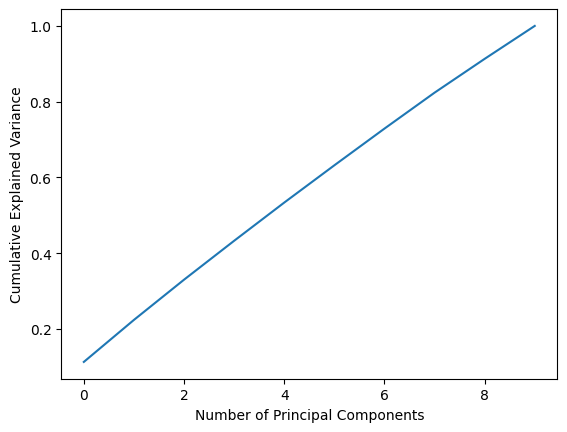

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

# generate a random dataset of shape (1000, 10)
X = np.random.randn(1000, 10)

# calculate the covariance matrix of X
covariance = np.cov(X.T)

# calculate the eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(covariance)

# sort the eigenvalues and eigenvectors in descending order of eigenvalue
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# calculate the cumulative explained variance
cumulative_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)

# plot the cumulative explained variance
import matplotlib.pyplot as plt
plt.plot(cumulative_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# choose the number of principal components to keep based on the cumulative explained variance plot
n_components = 5

# use scikit-learn's PCA to perform dimensionality reduction
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)


## Part 4: Stretch Goals
Include all your code used for part 4 in this section. You can copy-paste code from parts 1, 2 or 3 if it is re-usable.

#### PDFS after using PCA to rotate your data 	

In [7]:
# initialization code
import numpy as np
from keras.datasets import mnist
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA

In [8]:
# loads MNIST data and reformat to 768-d vectors with values in range 0 to 1
# splits into train/val/test sets and provides indices for subsets of train
def load_mnist():
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  x_train = np.reshape(x_train, (len(x_train), 28*28))
  x_test = np.reshape(x_test, (len(x_test), 28*28))
  maxval = x_train.max()
  x_train = x_train/maxval
  x_test = x_test/maxval
  x_val = x_train[:10000]
  y_val = y_train[:10000]
  x_train = x_train[10000:]
  y_train = y_train[10000:]
  train_indices = dict()
  train_indices['xs'] = np.arange(50)
  train_indices['s'] = np.arange(500)
  train_indices['m'] = np.arange(5000)
  train_indices['all'] = np.arange(50000)
  return (x_train, y_train), (x_val, y_val), (x_test, y_test), train_indices

In [9]:
# displays a set of mnist images (can print 1 row OR 1 column)
def display_mnist(x, subplot_rows=1, subplot_cols=1):
  s = np.ceil(max(subplot_rows, subplot_cols)/10)
  if subplot_rows>1 or subplot_cols>1:
      fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(15,15))
      for i in range(len(x)):
        ax[i].imshow(np.reshape(x[i], (28,28)), cmap='gray')
        ax[i].axis('off')
  else:
      plt.imshow(np.reshape(x, (28,28)), cmap='gray')
      plt.axis('off')
  plt.show()

In [10]:
# counts the number of examples per class
def class_count_mnist(y):
  count = np.zeros((10,),dtype='uint32')
  for i in np.arange(10):
    count[i] = sum(y==i)
  return count

In [11]:
# example of using MNIST load, display, indices, and count functions
(x_train, y_train), (x_val, y_val), (x_test, y_test), train_indices = load_mnist()

In [12]:
# Apply PCA to the data and get the first two principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_train)

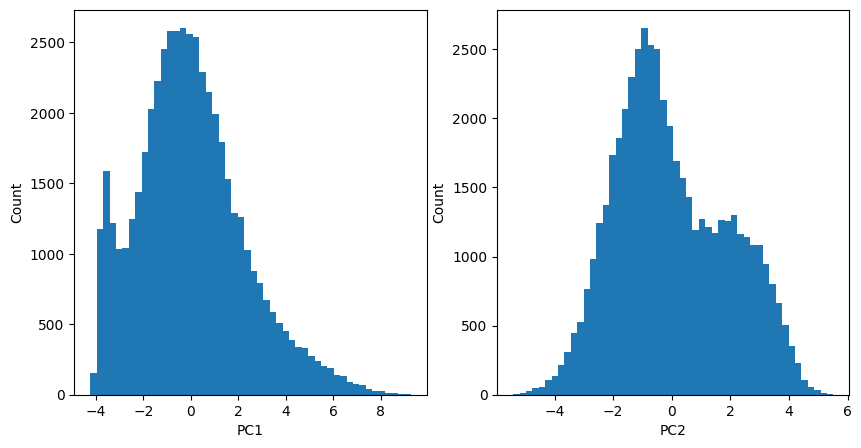

In [13]:
# Plot the PDFs of the principal components
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(X_pca[:, 0], bins=50)
plt.xlabel('PC1')
plt.ylabel('Count')
plt.subplot(1, 2, 2)
plt.hist(X_pca[:, 1], bins=50)
plt.xlabel('PC2')
plt.ylabel('Count')
plt.show()

scatterplots using MDS:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from keras.datasets import mnist

In [3]:
# load MNIST data and reshape it
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)
X = X.reshape(X.shape[0], -1)

In [4]:
# normalize the data to have zero mean and unit variance
X = X.astype('float32')
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X = (X - X_mean) / X_std

<ipython-input-4-b7b5a5670e7d>:5: RuntimeWarning: invalid value encountered in true_divide
  X = (X - X_mean) / X_std


In [5]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

In [23]:
# apply PCA to reduce the dimensionality of the data
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_imputed)

In [ ]:
# apply MDS to visualize the data in two dimensions
mds = MDS(n_components=2, n_jobs=-1)
X_mds = mds.fit_transform(X_pca)

# plot the data using different colors for each class
fig, ax = plt.subplots(figsize=(10, 10))
scatter = ax.scatter(X_mds[:, 0], X_mds[:, 1], c=y, cmap='jet')
legend = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend)
plt.show()

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


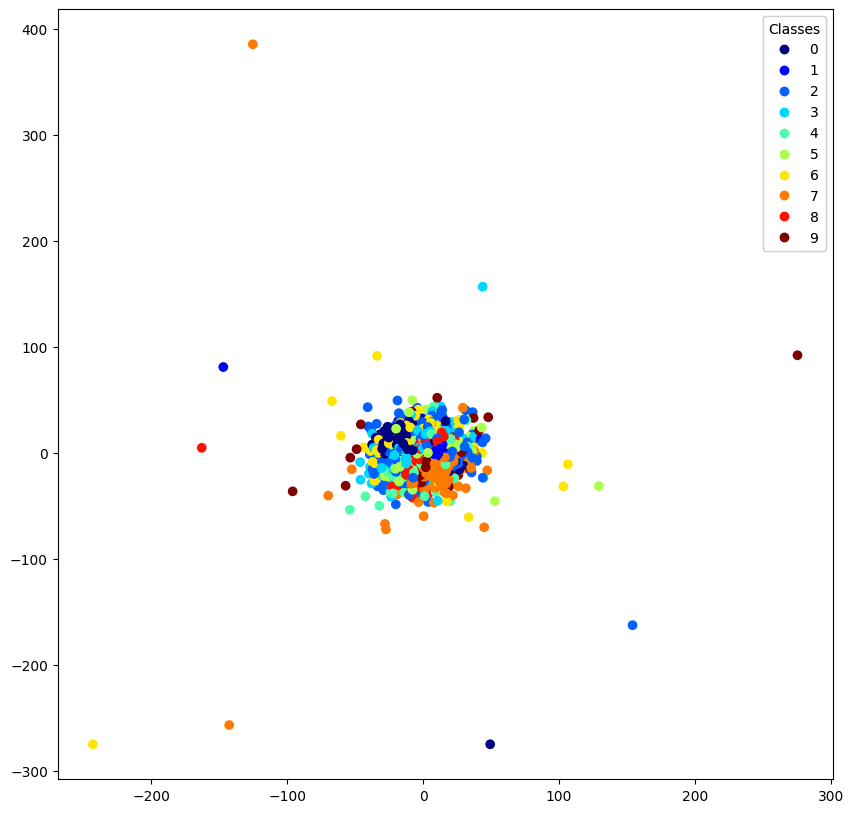

In [7]:
# randomly select 5000 samples for visualization
np.random.seed(42)
idx = np.random.choice(X.shape[0], size=5000, replace=False)
X_subset = X_imputed[idx]
y_subset = y[idx]

# apply PCA to reduce the dimensionality of the data
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_subset)

# apply MDS to visualize the data in two dimensions
mds = MDS(n_components=2, n_jobs=-1)
X_mds = mds.fit_transform(X_pca)

# plot the data using different colors for each class
fig, ax = plt.subplots(figsize=(10, 10))
scatter = ax.scatter(X_mds[:, 0], X_mds[:, 1], c=y_subset, cmap='jet')
legend = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend)
plt.show()


Using Linear Discriminant Analysis (LDA) instead of one of the above techniques:

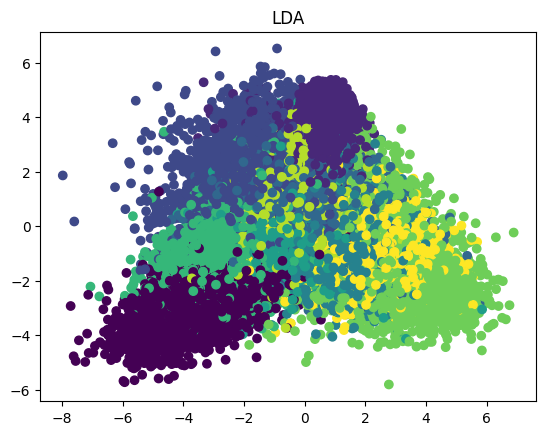

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

# Load your data here
(x_train, y_train), (x_val, y_val), (x_test, y_test), train_indices = load_mnist()

# Create LDA embedding
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(x_train, y_train)

# Create scatterplot
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y_train)
plt.title('LDA')
plt.show()
